[View in Colaboratory](https://colab.research.google.com/github/sungreong/Pymc3_bayseian-network/blob/master/Bayseian_Linear_Regression_in_Pymc3.ipynb)

In [1]:
!pip install git+https://github.com/pymc-devs/pymc3
!pip install patsy pandas    

  Cloning https://github.com/pymc-devs/pymc3 to /tmp/pip-req-build-an0bziqi
  Running setup.py bdist_wheel for pymc3 ... - \ | / - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-mqwe6g_a/wheels/a1/e3/71/a696f2af0dd40bccc0ce672d616d21cc9dd90dbdd3f03242f4
Successfully built pymc3


## Linear Regression 
베이지안 선형 회귀를  사전분포를 정규분포로 하여 만들어 보려고 한다. 

### Y ~ N( MU , SIGMA^2)  MU = ALPHA + BETA_1 * X_1 + BETA_2 * X_2

### ALPHA ~ N(0, 100)  BETA ~ N(0, 100) SIGAMA ~|N(0,1)|


generating data

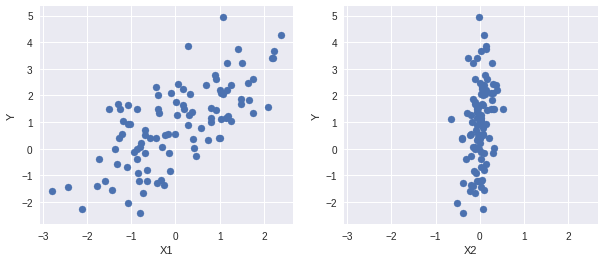

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

alpha , sigma = 1,1
beta = [1,2.5]

size= 100

X1 = np.random.randn(size)
X2 = np.random.randn(size)*0.2

Y = alpha +beta[0]*X1 + beta[1]*X2 +np.random.randn(size)*sigma

fig, axes = plt.subplots(1, 2, sharex= True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel("Y") ; axes[0].set_xlabel("X1") ;
axes[1].set_ylabel("Y") ; axes[1].set_xlabel("X2") ;

pymc3로 모델을 짜는것은 문법이 통계적인 명칭에 가깝게 사용하기 때문에 이해하기 쉽다. 

In [5]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


In [6]:
basic_model = pm.Model()  ## 모델 하나 생성 컨테이너 역할하는 것 빈통을 생성

with basic_model :  ##  이 안에서다가 구조를 짜면 된다 . 
    
    #   모델 파라미터로 잘 안알려진 사전분포 - 노말로 설정
    ## 이 과정은 stochastic random variables 생성을 한다. 
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=10,shape=2) # B_1, B_2 # SHAPE = DEFAULT= 1 SCALAR 값이다 하지만 (5,7) 등등 multidimensional array 생성가능
    sigma = pm.HalfNormal("sigma", sd=1)
    #T hese are stochastic because their values are partly determined by its parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic).
    
    # 결과의 기댓값
    mu = alpha + beta[0]*X1 + beta[1]*X2   ## Deterministic 랜덤 변수를 생성하는 것이다 (copletely determined by its par) 
    
    # 관측값에 따른 가능도함수
    Y_obs = pm.Normal("Y_obs" , mu=mu, sd=sigma, observed=Y)  ## the sampling distribution of the outcomes in the dataset. ==> observed stochastic, 
    
    
    ### the parameters for the normal distribution of Y_obs are not fixed values, 
    ### but rather are the deterministic object mu and the stochastic sigma. 
    ### This creates parent-child relationships between the likelihood and these two variables.
    

INFO (theano.gof.compilelock): Waiting for existing lock by process '110' (I am process '1022')
INFO (theano.gof.compilelock): To manually release the lock, delete /content/.theano/compiledir_Linux-4.4.111+-x86_64-with-Ubuntu-17.10-artful-x86_64-3.6.3-64/lock_dir


In [8]:
help(pm.Normal) ## help(basic_model)  help(Model), help(Uniform) 너무 길게나와서 안한다. 암튼 다양한 설명이 나온다.

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sds = [0.4, 1., 2., 0.4]
 |      for mu, sd in zip(mus, sds):
 |          pdf = st.norm.pdf(x, mu, sd)
 |          plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu, sd))
 |  

Model Fitting :  모델에서 알려지지 않은 변수의 사후 추정치를 얻기 위해서 사후 추정치를 계산해야 한다. 그러나 대부분의 중요하지 않은 모델의 경우 이것은 실현 가능하지 않습니다.


두가지 접근 방법이 있다


1.   MAP (maximum a posteriori)
2.   MCMC(Markov chain Monte Carlo)


## MAP 

모델에서 MAP 추정치는 사후분포의 MODE와 같다 그리고 수치적으로 최적화 방법으로 사용한다. 빠르고 쉽지만 모델에 잘 표현이 안되면 편향적인 것을 얻을 수도 있다. 

### find_MAP

The MAP is returned as a parameter point, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values.

By default, find_MAP uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior 

but also allows selection of other optimization algorithms from the scipy.optimize modul



In [11]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 1064.50it/s] 


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma': array(0.96298858),
 'sigma_log__': array(-0.03771373)}

For example, below we use Powell’s method to find the MAP.

In [12]:
from scipy import optimize

map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)

map_estimate

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -149.47:   4%|▎         | 176/5000 [00:00<00:02, 1704.95it/s]

Optimization terminated successfully.
         Current function value: 148.984564
         Iterations: 4
         Function evaluations: 176


{'alpha': array(0.90907964),
 'beta': array([0.9514399 , 2.61452795]),
 'sigma': array(0.96568062),
 'sigma_log__': array(-0.03492212)}

### 하지만 MAP가 항상 합리적인 것은 아니다 ( 특히 모델이 너무 극단적일 때는 ) 

with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small

(FOR EXAMPLE : hierarchical models with the variance parameter for the random effect )

Most techniques for finding the MAP estimate also only find a **local optimum** (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.

## Sampling methods

Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimate

## MCMC

be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the posterior distribution.

we specify a step method object that corresponds to a particular MCMC algorithm, such as **Metropolis,** Slice sampling, or **the No-U-Turn Sampler (NUTS)**.

### step_methods

**NUTS, Metropolis, Slice, HamiltonianMC, and BinaryMetropolis**


*  Binary variables will be assigned to BinaryMetropolis
*  Discrete variables will be assigned to Metropolis
*  Continuous variables will be assigned to NUTS

HAS A Sampling algorithms like **adaptive Metropolis-Hastings** and **adaptive slice sampling**

PyMC3’s most capable step method is the **No-U-Turn Sampler.** 

* NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. 
* It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. 
* This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. 
* NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo
* For random variables that are undifferentiable (namely, discrete variables) NUTS cannot be used, **but** it may still be used on the differentiable variables in a model that contains undifferentiable variables.

## SCALING MATRIX PARAMETER 
* NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although NUTS uses it somewhat differently. 
* The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions
* It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling
* This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions
* Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. 

##  ADVI (auto-diff variational inference).

Fortunately PyMC3 automatically initializes NUTS using another inference algorithm called ADVI (auto-diff variational inference). Moreover, PyMC3 will automatically assign an appropriate sampler 
 

In [13]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500) ## default NUTS SAMPLING Mehtod 

    ## sample 함수는 step method iteration 숫자가 주어진 만큼 할당하는 방법이다 sample 들을 모아준다. 
    
    ## trace 변수이름으로부터 numpy.array로 maping 해준다. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 1000/1000 [00:01<00:00, 783.48it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


In [20]:
print(trace["alpha"][0:10])
trace.varnames

[0.91317484 0.73306562 0.72035059 1.09205587 1.04631587 1.03124095
 0.9063969  0.9063969  0.90041314 0.86826209]


['alpha', 'beta', 'sigma_log__', 'sigma']

만약 NUTS 대신에 SIGMA를 샘플링에 사용하고 싶ㄷ마ㅕㄴ 가능하다.

In [23]:
with basic_model :
    start = pm.find_MAP(fmin = optimize.fmin_powell)
    
    # instaantiate sampler
    step = pm.Slice()
    
    trace = pm.sample(5000,step =step, start=start)

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -149.47:   4%|▎         | 176/5000 [00:00<00:03, 1578.80it/s]


Optimization terminated successfully.
         Current function value: 148.984564
         Iterations: 4
         Function evaluations: 176


Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [sigma_log__]
>Slice: [beta]
>Slice: [alpha]
 91%|█████████ | 4980/5500 [00:09<00:01, 498.91it/s]/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 5500/5500 [00:11<00:00, 498.71it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np

In [24]:
trace["alpha"][0:10]

array([0.86881666, 0.92551493, 0.95153437, 1.01471325, 0.84428572,
       0.88852815, 1.0219464 , 0.84787199, 0.9102821 , 0.87083577])

## Posterior analysis 
pymc3 plot 과 summarization 함수를 제공한다. 

왼쪽 컬럼은 각각 확률랜덤변수의 마지널 사후 히스토그램을 그려주고 

오른쪽 컬럼은 순서대로 마코프 체인의 샘플을 포함하고 있다. 

beta 변수는 두개의 히스토그램이 생성된다 그리고 계수에 따라서 trace가 생성된다. 

summary 함수는 공통의 사후 계산치를 제공한다.


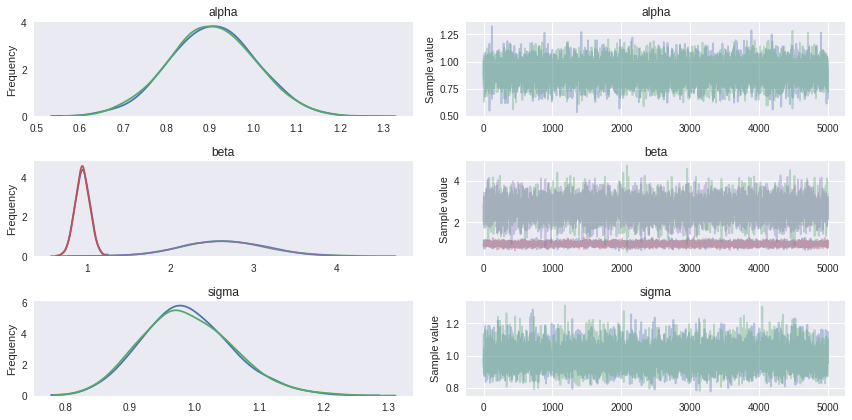

In [26]:
_ = pm.traceplot(trace)

In [27]:
pm.summary(trace)

/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.905998,0.099738,0.000999,0.707610,1.099741,9794.550908,1.000150
beta__0,0.946966,0.088491,0.000944,0.774196,1.120322,9950.187470,1.000024
beta__1,2.647733,0.502535,0.005233,1.688464,3.670133,8430.896186,0.999959
sigma,0.989538,0.071229,0.000835,0.858421,1.134602,8356.340935,0.999900
